In [1]:
import os
import sys
from tqdm import tqdm

import h5py
import yaml
import torch
import random
import numpy as np
from ema_pytorch import EMA
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from torchmetrics.functional.image import (
    peak_signal_noise_ratio,
    structural_similarity_index_measure,
    multiscale_structural_similarity_index_measure
)
from torchmetrics.functional.regression import mean_absolute_error, mean_squared_error

sys.path.append('../../tta_uia_segmentation/src/')

from models import ConditionalGaussianDiffusion

np.random.seed(1234)
random.seed(1234)


In [2]:
metrics_to_log_default = {
    'PSNR': peak_signal_noise_ratio,
    'SSIM': structural_similarity_index_measure,
    'MSSIM': multiscale_structural_similarity_index_measure,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error
}

In [3]:
def plot_denoising_progress(img_gt, seg_gt, img_w_noise, ex_img_w_noise_ti, img_denoised_sampled, img_denoised, noise_T, t_i):
    fig, ax = plt.subplots(1, 6, figsize=(30, 5))
    ax[0].imshow(img_gt.squeeze().numpy(), cmap='gray')
    ax[0].set_title('Original')

    ax[1].imshow(seg_gt.squeeze().numpy(), cmap='viridis')
    ax[1].set_title('Segmentation GT')

    ax[2].imshow(img_w_noise.squeeze().numpy(), cmap='gray')
    ax[2].set_title(f'Starting Noised img @ T={noise_T}')
    
    ax[3].imshow(ex_img_w_noise_ti.squeeze().numpy(), cmap='gray')
    ax[3].set_title(f'Example of Noised img @ t={t_i}')

    ax[4].imshow(img_denoised_sampled.squeeze().numpy(), cmap='gray')
    ax[4].set_title(f'Denoised - sampled t={t_i}')

    ax[5].imshow(img_denoised.squeeze().numpy(), cmap='gray')
    ax[5].set_title(f'Denoised img est. t=0 @ t={t_i}')
    
    plt.show()

In [4]:
def evaluate_linear_denoising(
    img: np.ndarray,
    seg: np.ndarray,
    n_classes: int,
    t: int,
    ddpm: GaussianDiffusion,
    plot_every: int = 50,
    measure_metrics_every: int = 5,
    metrics: dict = metrics_to_log_default
) -> dict[str, dict]: 
    
    # Normalize image
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
    img = ddpm.normalize(img)
    
    # Normalize segmentation
    x_cond = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0).float()
    x_cond = x_cond / (n_classes - 1)
    x_cond = ddpm.normalize(x_cond)

    # Generate noised verion of the image
    t_tch = torch.full((1,), t)
    noise = torch.randn_like(img)
    noised_img = ddpm.q_sample(img, t_tch, noise)

    img_denoised = noised_img
    metrics_logs = {k: list() for k in metrics.keys()}

    for t_i in tqdm(reversed(range(0, t)), desc = 'sampling loop time step', total = t):
        img_denoised_at_ti, img_denoised_at_t0 = ddpm.p_sample(img_denoised, t_i, x_cond)
        
        example_noised_img_at_ti = ddpm.q_sample(img, torch.full((1,), t_i), torch.randn_like(img))
        
        if t_i % plot_every == 0 or t_i == 0:
            plot_denoising_progress(img, x_cond, noised_img, example_noised_img_at_ti,
                                    img_denoised_at_ti, img_denoised_at_t0, t, t_i)
            
        if t_i % measure_metrics_every == 0 or t_i == 0:
            for metric_name, metric_log in metrics_logs.items():
                metric_log.append((
                    t - t_i,
                    metrics_to_log_default[metric_name](img, img_denoised_at_ti).item(),
                    metrics_to_log_default[metric_name](img, img_denoised_at_t0).item()
                ))
                
    return metrics_logs

# Load the data

In [5]:
ds_fp = '/scratch_net/biwidl319/jbermeo/logs/brain/preprocessing/hcp_t1/data_T1_2d_size_256_256_depth_256_res_0.7_0.7_from_0_to_20.hdf_normalized_with_nn.h5'
ds_h5 = h5py.File(ds_fp, 'r')

img_size = 256
n_classes = 15
vol_idx = random.randint(0, int(ds_h5['images'].shape[0]/img_size))
slice_idx = random.randint(int(0.2 * img_size), int(0.8 * img_size))
rand_img = ds_h5['images'][vol_idx * img_size + slice_idx, :, :]
seg = ds_h5['labels'][vol_idx * img_size + slice_idx, :, :]
seg = seg 

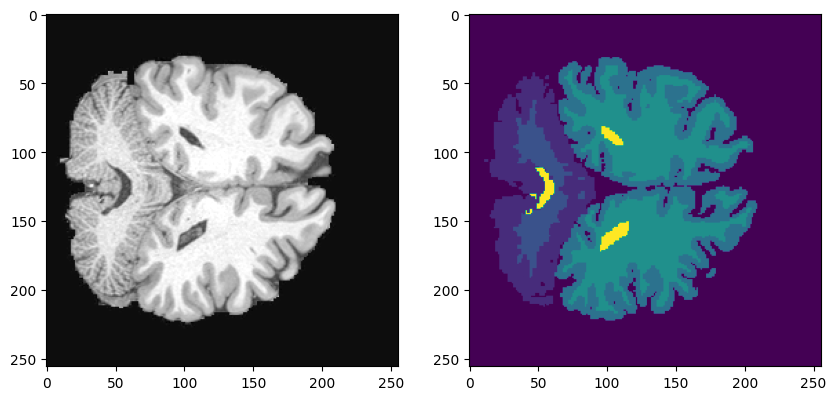

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rand_img, cmap='gray')
ax[1].imshow(seg, cmap='viridis')
plt.show()

# Check how the noise sampling looks like

In [7]:
denoise_model = Unet(
    dim = 16,
    dim_mults = (1, 2),   
    flash_attn = True,
    channels= 1, 
    self_condition=True,
)#.to(device)

ddpm = ConditionalGaussianDiffusion(
    denoise_model,
    image_size=img_size
)

/itet-stor/jbermeo/net_scratch/conda_envs/ddpm/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
t = 150
t = torch.full((1,), t)
img = torch.from_numpy(rand_img).unsqueeze(0).unsqueeze(0).float()
noise = torch.randn_like(img)

noised_img = ddpm.q_sample(rand_img, t, noise)

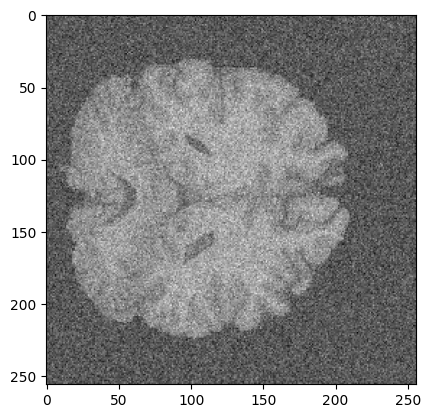

In [9]:
plt.imshow(noised_img.squeeze().detach().numpy(), cmap='gray')

# Behaviour in a trained model

### Load the checkpointed model

In [10]:
run_params = yaml.safe_load(
    open('/scratch_net/biwidl319/jbermeo/logs/brain/cddpm/params.yaml', 'r'))
cpt_path = '/scratch_net/biwidl319/jbermeo/logs/brain/cddpm/model-64.pt'

In [11]:
train_config = run_params['training']['ddpm']

timesteps           = train_config['timesteps']
sampling_timesteps  = train_config['sampling_timesteps']

# Model definition
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),   
    flash_attn = True,
    channels=1, 
    self_condition=True,
)#.to(device)

ddpm = ConditionalGaussianDiffusion(
    model,
    image_size = 256,
    timesteps = timesteps,    # Range of steps in diffusion process
    sampling_timesteps = sampling_timesteps 
)

In [12]:
cpt = torch.load(cpt_path, map_location='cpu')

In [13]:
ema_update_every = 10
ema_decay = 0.995
ddpm_ema = EMA(ddpm, beta = ema_decay, update_every = ema_update_every)
ddpm_ema.load_state_dict(cpt['ema'])

<All keys matched successfully>

## How does the denoising inference function look like

sampling loop time step:   1%|          | 4/400 [00:04<07:01,  1.07s/it]

sampling loop time step:  12%|█▏        | 49/400 [00:58<06:50,  1.17s/it]

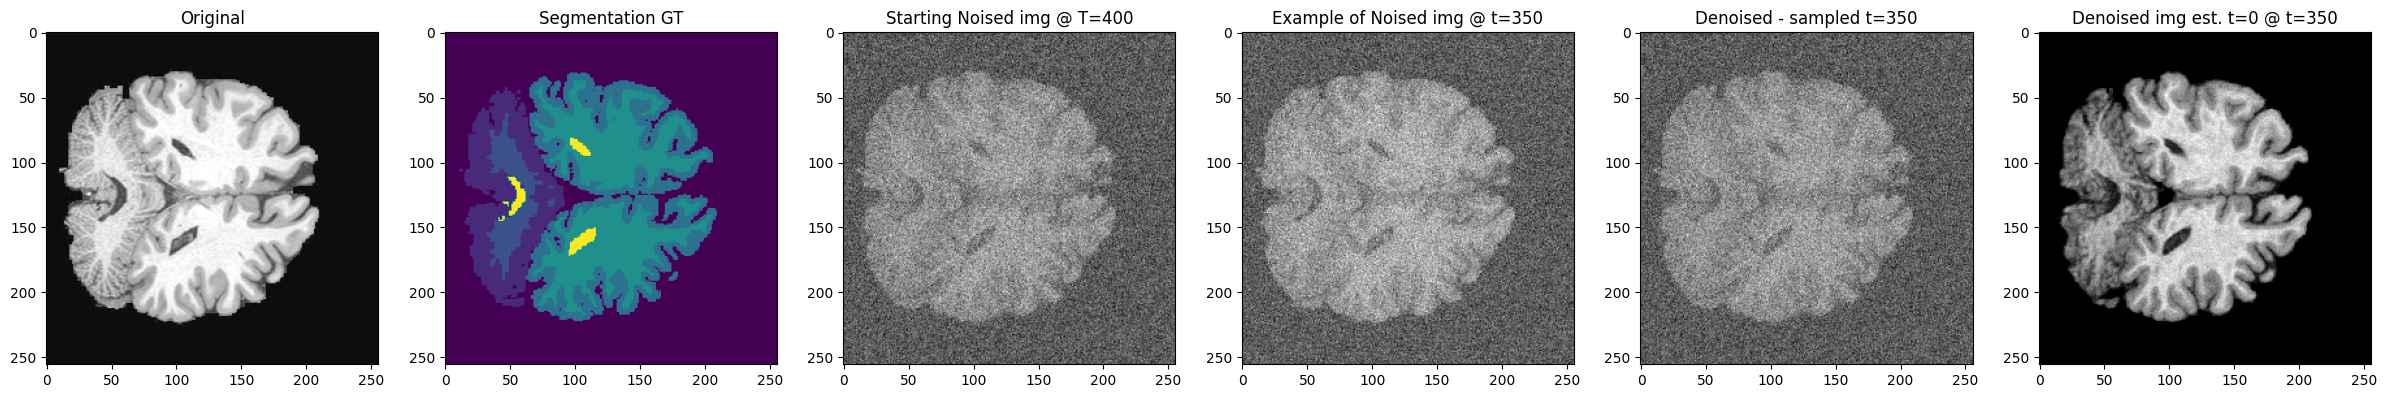

sampling loop time step:  25%|██▍       | 99/400 [02:00<06:22,  1.27s/it]

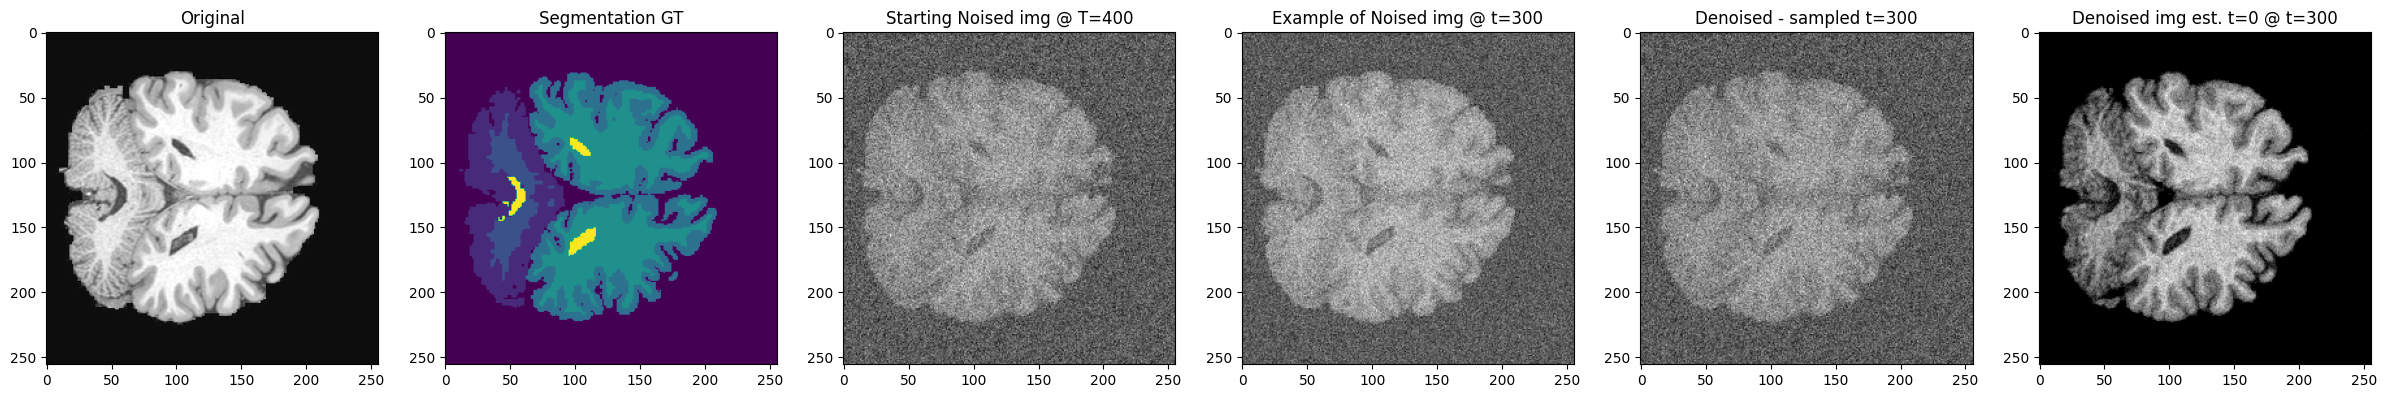

sampling loop time step:  37%|███▋      | 149/400 [03:03<04:25,  1.06s/it]

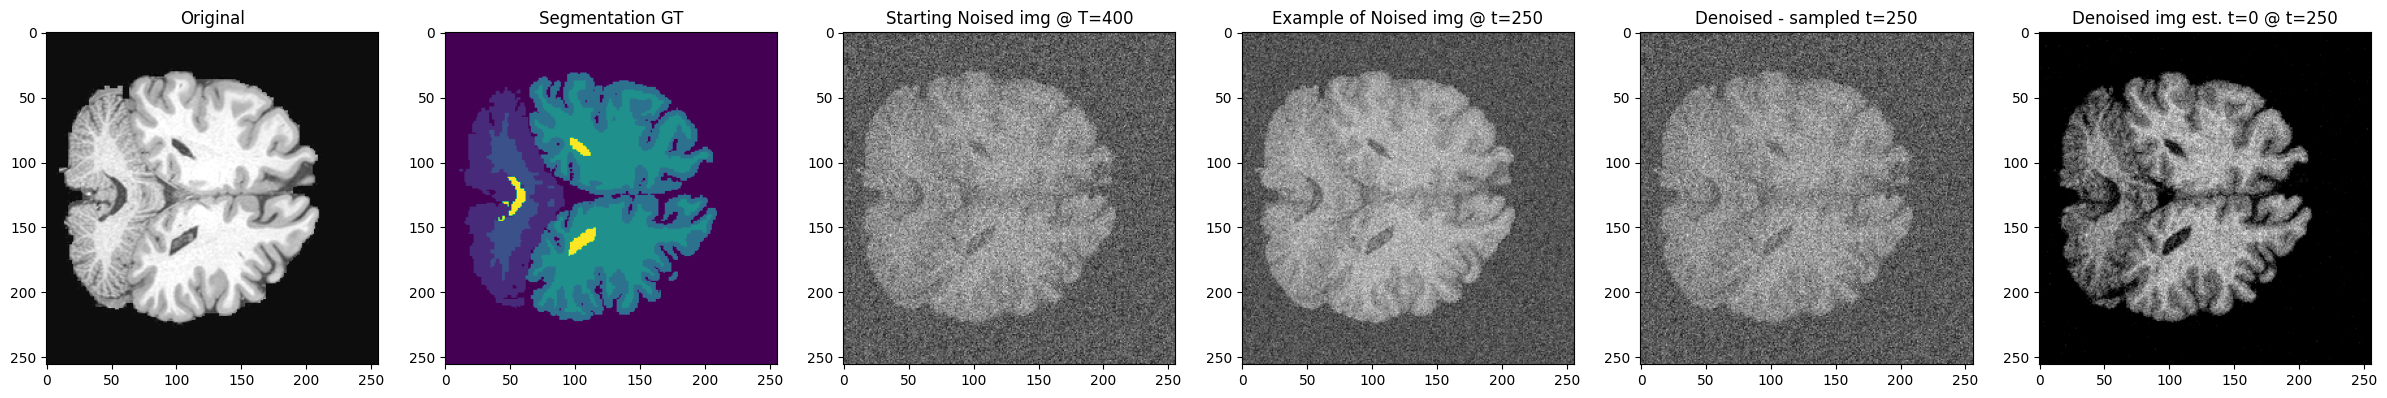

sampling loop time step:  50%|████▉     | 199/400 [04:08<04:05,  1.22s/it]

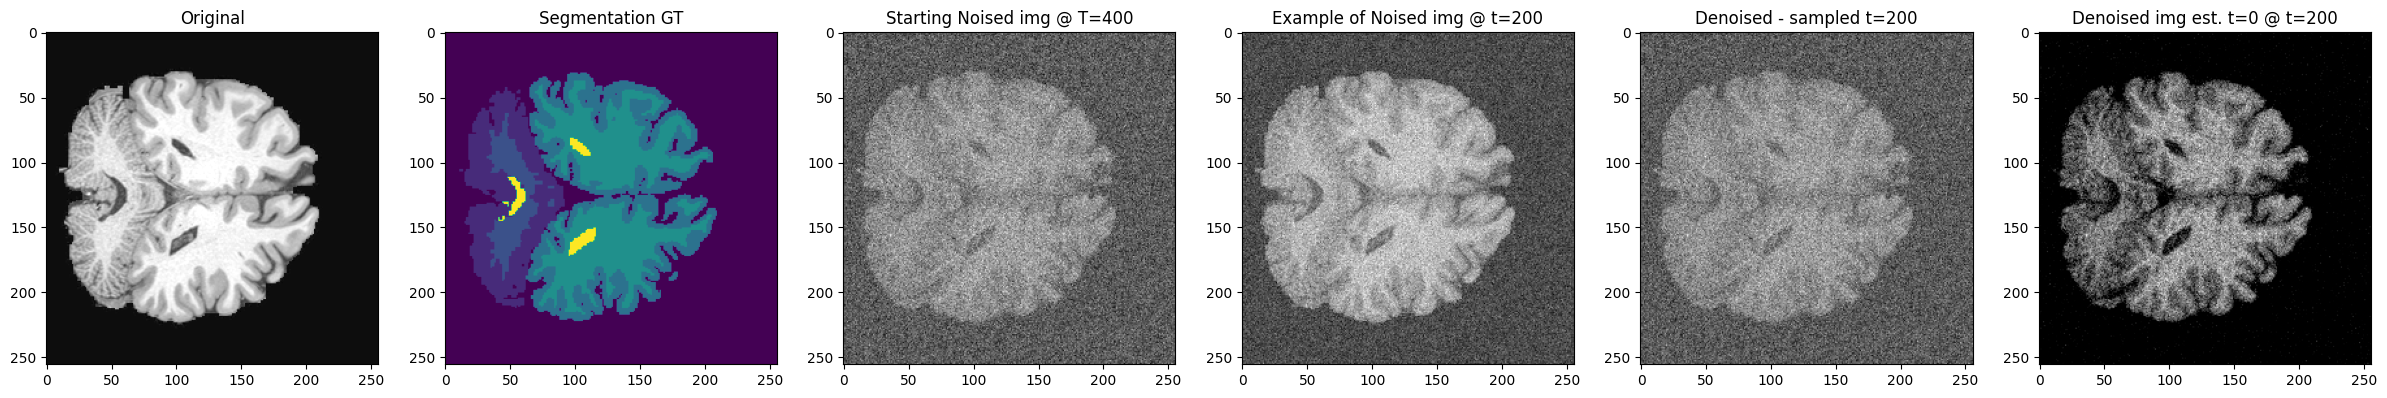

sampling loop time step:  61%|██████    | 244/400 [05:04<03:40,  1.41s/it]

In [14]:
t = 400
plot_every = 50
measure_metrics_every = 5

metrics = evaluate_linear_denoising(
    img=rand_img,
    seg=seg,
    n_classes=n_classes,
    t=t,
    ddpm=ddpm_ema.model,
    plot_every=plot_every
) 

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 0], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 2], label=metric_name)
    plt.legend()
    plt.show()

## How does slight noising and denoising look like

In [ ]:
t = 50
plot_every = 50
measure_metrics_every = 5

metrics = evaluate_linear_denoising(
    img=rand_img,
    seg=seg,
    n_classes=n_classes,
    t=t,
    ddpm=ddpm_ema.model,
    plot_every=plot_every
) 

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 1], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 2], label=metric_name)
    plt.legend()
    plt.show()

### Let's try with a medium ammount of noise

In [ ]:
t = 200
metrics = evaluate_linear_denoising(
    img=rand_img,
    seg=seg,
    n_classes=n_classes,
    t=t,
    ddpm=ddpm_ema.model,
) 

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 1], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

In [ ]:
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 2], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

### Let's try with a stronger noise

In [ ]:
t = 500
plot_every = 50

metrics = evaluate_linear_denoising(
    img=rand_img,
    seg=seg,
    n_classes=n_classes,
    t=t,
    ddpm=ddpm_ema.model,
) 

for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 1], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()
    
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 2], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

In [ ]:
t = 800
plot_every = 100

metrics = evaluate_linear_denoising(
    img=rand_img,
    seg=seg,
    n_classes=n_classes,
    t=t,
    ddpm=ddpm_ema.model,
    plot_every=plot_every
) 

for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 1], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()
    
for metric_name, metric_log in metrics.items():
    plt.plot(np.array(metric_log)[:, 2], np.array(metric_log)[:, 1], label=metric_name)
    plt.legend()
    plt.show()

## How does DDIM sampling behave?

### When used on smaller noising levels